In [1]:
import sys
sys.path.append("..")
from lsst.daf.butler import Butler
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import multiprocessing
import evals
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
collection = "u/kmrakovc/runs/single_frame_injection_stars_full"
#collection = "u/kmrakovc/runs/single_frame_injection_test_full"
repo_path ="/epyc/ssd/users/kmrakovc/DATA/rc2_subset/SMALL_HSC/"

In [3]:
def measure_one_src_catalog(butler, collection, src_ref, calexp_ref, index):
    src = butler.get("src",
                     dataId=src_ref.dataId,
                     collections=collection)
    photocalib = butler.get("calexp.photoCalib",
                            dataId=calexp_ref.dataId,
                            collections=collection)
    wcs = butler.get("calexp.wcs",
                     dataId=calexp_ref.dataId,
                     collections=collection)
    s1 = src[src['parent']==0]
    snr = np.array(s1["base_PsfFlux_instFlux"])/np.array(s1["base_PsfFlux_instFluxErr"])
    magnitude = photocalib.instFluxToMagnitude(s1, 'base_PsfFlux')
    detection_origins = wcs.skyToPixelArray(np.array([s1["coord_ra"]]),
                                            np.array([s1["coord_dec"]]),
                                            degrees=False)
    sources = s1.asAstropy()
    sources["snr"]=snr
    sources["magnitude"]=magnitude[:,0]
    sources["magnitudeErr"]=magnitude[:,1]
    sources["n"]=index
    sources["y"]=np.round(detection_origins[0])
    sources["x"]=np.round(detection_origins[1])
    return sources.to_pandas()

def measure_src_catalog (repo_path, collection, val_index=None, n_parallel=0):
    butler = Butler(repo_path)
    calexp_ref = np.unique(np.array(list(butler.registry.queryDatasets("calexp",
                                                                       collections=collection,
                                                                       instrument='HSC',
                                                                       findFirst=True))))
    src_ref = np.unique(np.array(list(butler.registry.queryDatasets("src",
                                                                    collections=collection,
                                                                    instrument='HSC',
                                                                    findFirst=True))))
    if val_index is None:
        val_index = list(range(len(src_ref)))
    parameters = [(butler, collection, calexp_ref[i], src_ref[i], i) for i in val_index]
    if n_parallel > 1:
        with multiprocessing.Pool(n_parallel) as pool:
            results = pool.starmap(measure_one_src_catalog, parameters)
    else:
        results = [None] * len(parameters)
        for i, p in enumerate(parameters):
            results[i] = measure_one_src_catalog(*p)
            print("\r", i + 1, "/", len(parameters), end="")
    results = pd.concat(results).reset_index(drop=True)
    return results

In [4]:
def cutouts_by_snr_bins (repo_path, collection, sources, snr=[5, 10, 15, 20, 25, 30], cutout_size=20, calexp_type="calexp"):
    snr_column_name=[col for col in sources.columns if 'snr' in col][0]
    mag_column_name=[col for col in sources.columns[sources.dtypes==float] if 'mag' in col]
    butler = Butler(repo_path)
    calexp_ref = np.unique(np.array(list(butler.registry.queryDatasets(calexp_type,
                                                                       collections=collection,
                                                                       instrument='HSC',
                                                                       findFirst=True))))
    calexp_dimensions = butler.get(calexp_type+".dimensions",
                                   dataId=calexp_ref[0].dataId,
                                   collections=collection)
    sources = sources[(sources[snr_column_name]>0) & (sources["x"]>3*cutout_size) & (sources["y"]>3*cutout_size)]
    sources = sources[(sources["x"]<calexp_dimensions.y-3*cutout_size) & (sources["y"]<calexp_dimensions.x-3*cutout_size)]
    fig, ax = plt.subplots(1, len(snr), figsize=(len(snr)*2.7, 1*4))
    for i, s in enumerate(snr):
        source_info = sources.iloc[[np.argsort(np.square(np.array(sources[snr_column_name]-s)))[0]]][["n","x","y", snr_column_name]+mag_column_name]
        calexp = butler.get(calexp_type, dataId=calexp_ref[source_info["n"].values[0]].dataId, collections=collection).image.array
        x = int(source_info["x"].values[0])
        y = int(source_info["y"].values[0])
        cutout = calexp[x-cutout_size:x+cutout_size, 
                        y-cutout_size:y+cutout_size]
        ax[i].imshow(cutout, vmin=calexp.mean()-3*calexp.std(), vmax=calexp.mean()+3*calexp.std(), cmap="gray")
        ax[i].set_xticks([])
        ax[i].set_yticks([])
        ax[i].set_title("SNR="+str(round(source_info[snr_column_name].values[0],2)))
        x_label = ""
        for col_name in mag_column_name:
            x_label += col_name+":"+str(round(source_info[col_name].values[0],2))+"\n"
        ax[i].set_xlabel(x_label)
    fig.tight_layout()
    
def cutouts_of_one_snr (repo_path, collection, sources, sources_num=5, snr=5, cutout_size=20, calexp_type="calexp"):
    snr_column_name=[col for col in sources.columns if 'snr' in col][0]
    mag_column_name=[col for col in sources.columns[sources.dtypes==float] if 'mag' in col]
    butler = Butler(repo_path)
    calexp_ref = np.unique(np.array(list(butler.registry.queryDatasets(calexp_type,
                                                                       collections=collection,
                                                                       instrument='HSC',
                                                                       findFirst=True))))
    calexp_dimensions = butler.get(calexp_type+".dimensions",
                                   dataId=calexp_ref[0].dataId,
                                   collections=collection)
    sources = sources[(sources[snr_column_name]>0) & (sources["x"]>3*cutout_size) & (sources["y"]>3*cutout_size)]
    sources = sources[(sources["x"]<calexp_dimensions.y-3*cutout_size) & (sources["y"]<calexp_dimensions.x-3*cutout_size)]
    fig, ax = plt.subplots(1, sources_num, figsize=(sources_num*3, 1*3))
    for i in range(sources_num):
        source_info = sources.iloc[[np.argsort(np.square(np.array(sources[snr_column_name]-snr)))[i]]][["n","x","y", snr_column_name]+mag_column_name]
        calexp = butler.get(calexp_type, dataId=calexp_ref[source_info["n"].values[0]].dataId, collections=collection).image.array
        x = int(source_info["x"].values[0])
        y = int(source_info["y"].values[0])
        cutout = calexp[x-cutout_size:x+cutout_size, 
                        y-cutout_size:y+cutout_size]
        ax[i].imshow(cutout, vmin=calexp.mean()-3*calexp.std(), vmax=calexp.mean()+3*calexp.std(), cmap="gray")
        ax[i].set_xticks([])
        ax[i].set_yticks([])
        ax[i].set_title("SNR="+str(round(source_info[snr_column_name].values[0],2)))
        x_label = ""
        for col_name in mag_column_name:
            x_label += col_name+":"+str(round(source_info[col_name].values[0],2))+"\n"
        ax[i].set_xlabel(x_label)
    fig.tight_layout()

In [5]:
sources = measure_src_catalog (repo_path, collection, n_parallel=30)
sources

id  coord_ra  coord_dec  parent  calib_detected  \
0         138385993760769  2.622788   0.038241       0           False   
1         138385993760770  2.622799   0.038103       0           False   
2         138385993760771  2.622801   0.037990       0            True   
3         138385993760772  2.622799   0.036898       0           False   
4         138385993760773  2.622797   0.037088       0           False   
...                   ...       ...        ...     ...             ...   
635322  13095479839558932  2.616291   0.039411       0           False   
635323  13095479839558933  2.618557   0.039001       0           False   
635324  13095479839558934  2.615538   0.038374       0           False   
635325  13095479839558935  2.617800   0.039207       0           False   
635326  13095479839558936  2.616668   0.038791       0           False   

        calib_psf_candidate  calib_psf_used  calib_psf_reserved  coord_raErr  \
0                     False           False               False          NaN   
1                     False           False               False          NaN   
2                     False           False               False          NaN   
3                     False           False               False          NaN   
4                     False           False               False          NaN   
...                     ...             ...                 ...          ...   
635322                False           False               False          NaN   
635323                False           False               False          NaN   
635324                False           False               False          NaN   
635325                False           False               False          NaN   
635326                False           False               False          NaN   

        coord_decErr  ...  base_FootprintArea_value  calib_astrometry_used  \
0                NaN  ...                      6022                  False   
1                NaN  ...                       271                  False   
2                NaN  ...                       523                  False   
3                NaN  ...                       152                  False   
4                NaN  ...                      2390                  False   
...              ...  ...                       ...                    ...   
635322           NaN  ...                       197                  False   
635323           NaN  ...                       197                  False   
635324           NaN  ...                       197                  False   
635325           NaN  ...                       197                  False   
635326           NaN  ...                       197                  False   

        calib_photometry_used  calib_photometry_reserved         snr  \
0                       False                      False    4.934185   
1                       False                      False   10.260708   
2                       False                      False  134.812888   
3                       False                      False    8.411123   
4                       False                      False  832.042673   
...                       ...                        ...         ...   
635322                  False                      False   -0.272275   
635323                  False                      False   -1.201601   
635324                  False                      False   -0.548335   
635325                  False                      False   -0.377155   
635326                  False                      False   -0.722419   

        magnitude  magnitudeErr    n       y       x  
0       22.703369      0.220047    0     9.0    25.0  
1       22.771762      0.105821    0   179.0    11.0  
2       19.926786      0.008132    0   317.0     9.0  
3       22.993009      0.129088    0  1656.0     9.0  
4       17.729564      0.001723    0  1423.0    12.0  
...           ...           ...  ...     

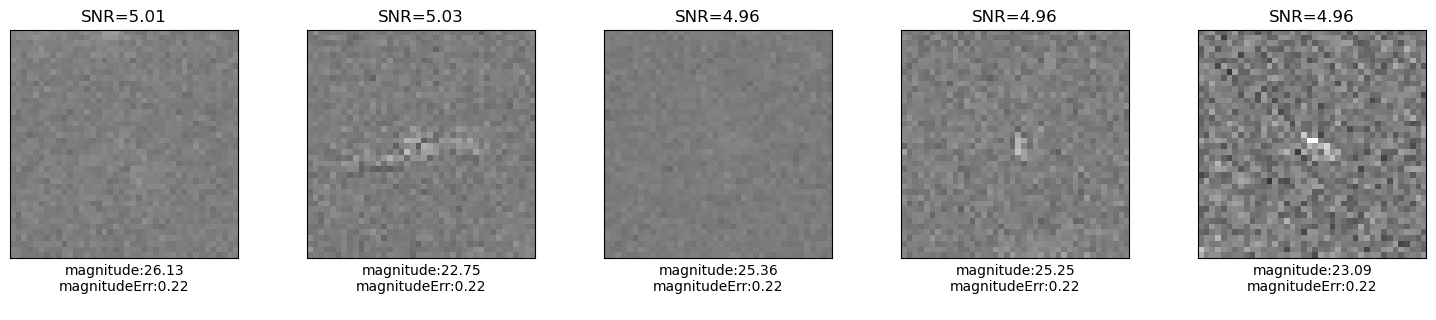

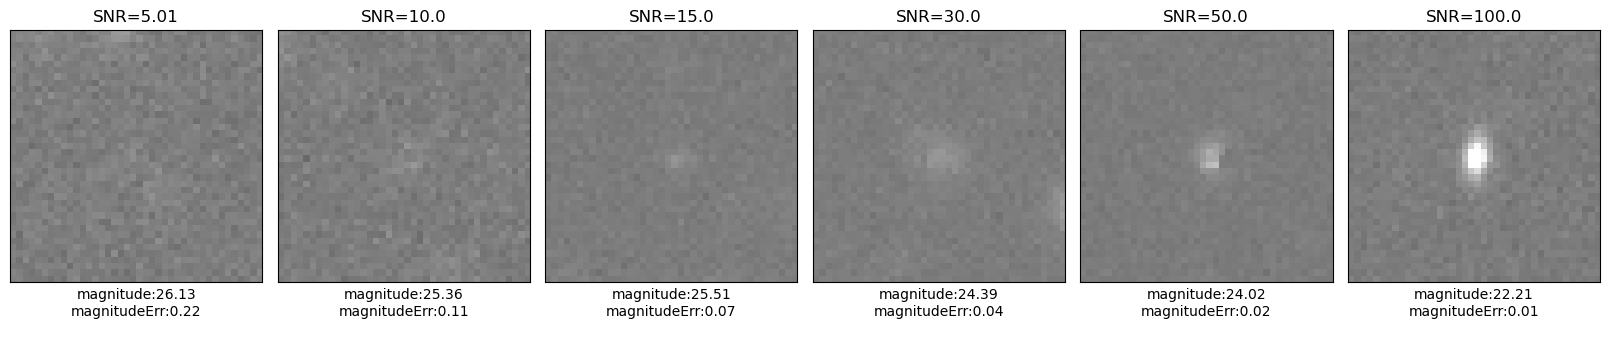

In [6]:
cutouts_of_one_snr (repo_path, collection, sources, snr=5)
cutouts_by_snr_bins (repo_path, collection, sources, snr=[5, 10, 15, 30, 50, 100])

Text(0.5, 0, 'Magnitude')

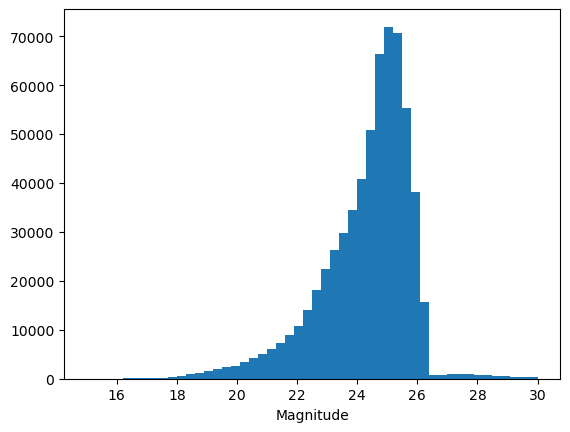

In [7]:
fig, ax = plt.subplots()
ax.hist(sources["magnitude"], bins=50, range=(15, 30))
ax.set_xlabel("Magnitude")

Text(0, 0.5, 'SNR')

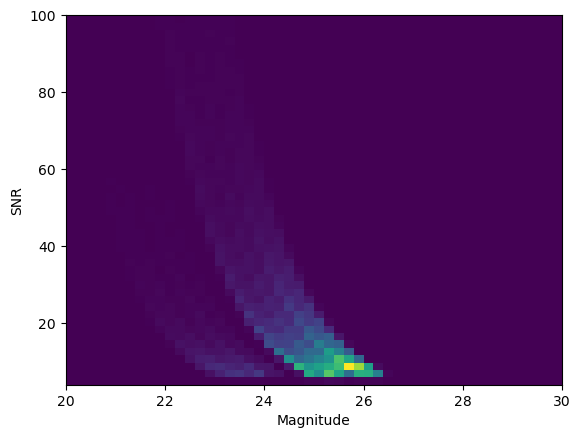

In [8]:
fig, ax = plt.subplots()
ax.hist2d(sources["magnitude"], sources["snr"], bins=50, range=[[20, 30], [4, 100]])
ax.set_xlabel("Magnitude")
ax.set_ylabel("SNR")

In [9]:
inject_sources = evals.eval_tools.recovered_sources(repo_path, collection, n_parallel=30)
detected_sources = inject_sources[inject_sources["stack_detected"]==1]
detected_sources

ra       dec source_type  trail_length        mag        beta  \
10    150.579394  2.253592       Trail           1.0  21.356825   50.618656   
12    150.669271  2.262448       Trail           1.0  21.143750  122.022770   
16    150.632628  2.262430       Trail           1.0  21.182094  136.091918   
23    149.942485  2.371372       Trail           1.0  21.073760  157.575901   
24    150.030198  2.392067       Trail           1.0  21.304472  149.261922   
...          ...       ...         ...           ...        ...         ...   
4638  150.615425  2.173943       Trail           1.0  20.318846   53.503744   
4647  150.097841  2.149820       Trail           1.0  21.414332   13.618660   
4660  150.071428  2.126911       Trail           1.0  20.814405   34.026884   
4672  150.158842  2.150561       Trail           1.0  20.374736   24.257481   
4678  150.011443  2.100706       Trail           1.0  20.196532   33.793920   

      visit  integrated_mag    PSF_mag physical_filter  surface_brightness  \
10    23706       21.356825  21.381326               r           21.356825   
12    23706       21.143750  21.168251               r           21.143750   
16    23706       21.182094  21.206595               r           21.182094   
23    11696       21.073760  21.095425               g           21.073760   
24    11696       21.304472  21.326137               g           21.304472   
...     ...             ...        ...             ...                 ...   
4638  23694       20.318846  20.343358               r           20.318846   
4647  30490       21.414332  21.439305               i           21.414332   
4660   1242       20.814405  20.839409               i           20.814405   
4672   1242       20.374736  20.399741               i           20.374736   
4678   1242       20.196532  20.221536               i           20.196532   

      detector band    n     x     y  stack_detected  stack_magnitude  \
10          47    r  112  2148   894               1        25.804661   
12          47    r  112   136   703               1        23.982816   
16          47    r  112   961   703               1        25.169253   
23          58    g  208  1475  1547               1        24.897249   
24          58    g  208  3348  1985               1        24.894789   
...        ...  ...  ...   ...   ...             ...              ...   
4638        47    r  110  3197   812               1        24.283679   
4647        49    i  154  3028   741               1        22.692434   
4660        42    i   49  1386   948               1        24.853470   
4672        42    i   49  3253  1454               1        24.130807   
4678        42    i   49   101   386               1        24.147038   

      stack_snr  
10     7.252068  
12    35.367753  
16    12.718783  
23    17.383626  
24    18.019597  
...         ...  
4638  42.291737  
4647  77.953141  
4660   8.125011  
4672  15.990336  
4678  15.232050  

[893 rows x 19 columns]

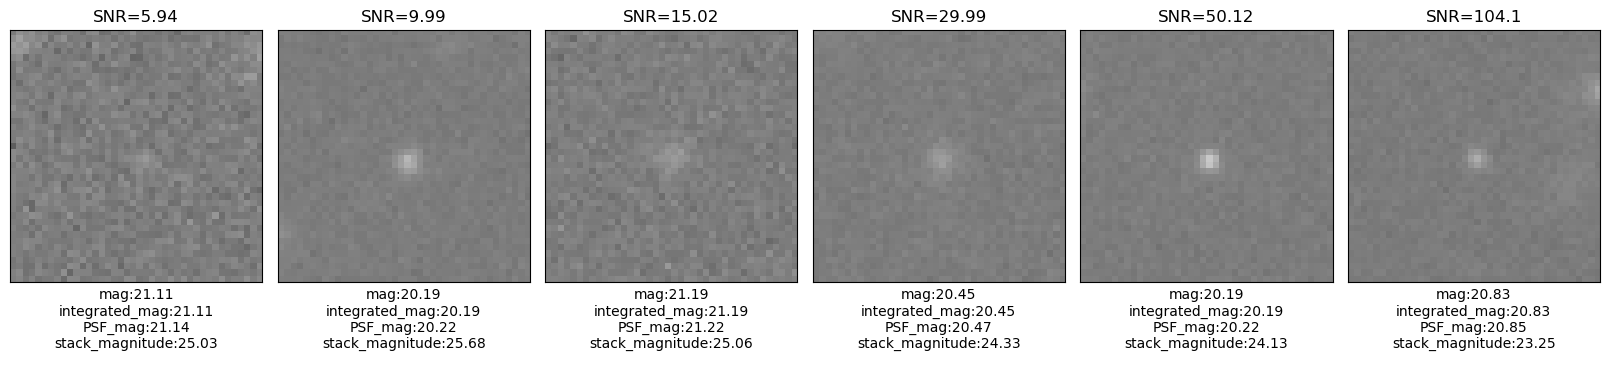

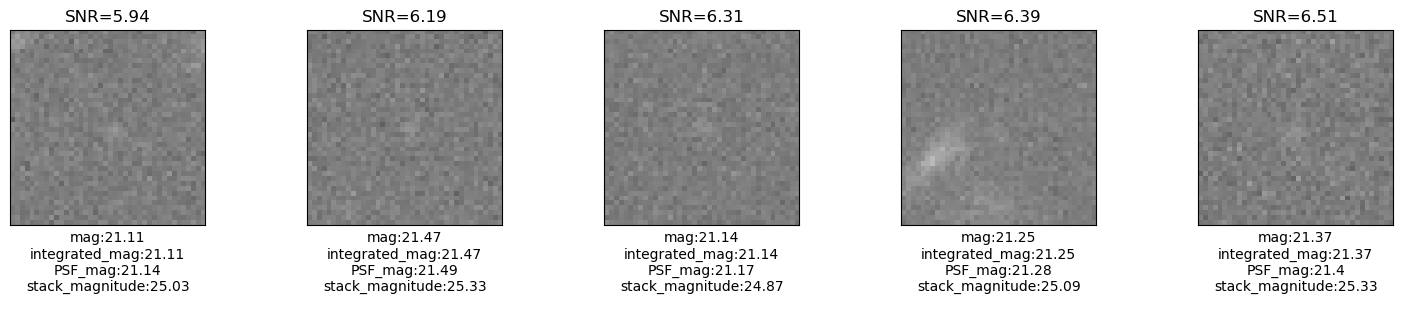

In [10]:
cutouts_by_snr_bins (repo_path, collection, detected_sources, snr=[5, 10, 15, 30, 50, 100], calexp_type="injected_calexp")
cutouts_of_one_snr (repo_path, collection, detected_sources, snr=5, calexp_type="injected_calexp")